This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,
 * calculates the central noise level
 * calculates tniti

In [2]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.gridspec as gridspec

import component_separation.MSC.MSC.pospace as ps

from lerepi.config.cmbs4.data import data_08d as sims_if
sims  = sims_if.ILC_May2022('00')

simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

MSC: reverting to standard healpy


In [3]:
def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

# Plm

*** Could only build up to itr number 2


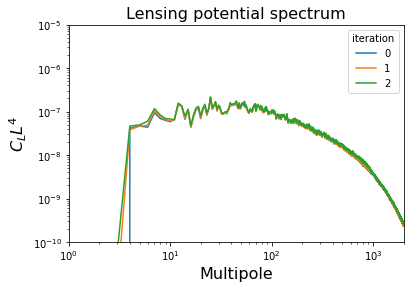

In [53]:
from lenscarf.iterators.statics import rec as rec
# from itercurv.iterators.statics import rec as rec
libdir_iterator = '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_rinf_tol4/p_p_sim0000/'
# libdir_iterator = '/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/zb_terator_p_p_0000_nofg_OBD_solcond_3apr20/'
plms = rec.load_plms(libdir_iterator, range(12))
for n in range(len(plms)):
    pcl = hp.alm2cl(plms[n])
    plt.plot(pcl*np.arange(len(pcl))**4, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(title='iteration')
plt.xlim(1e0,2e3)
plt.ylim(1e-10,1e-5)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)
plt.title('Lensing potential spectrum', fontsize=16)
pmaps = np.array([hp.alm2map(p, nside=2048) for p in plms])

# OBD

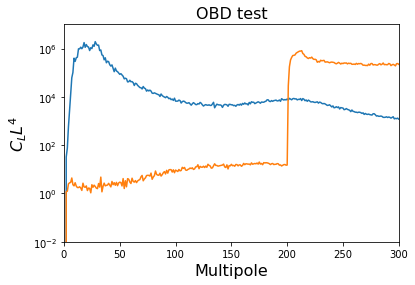

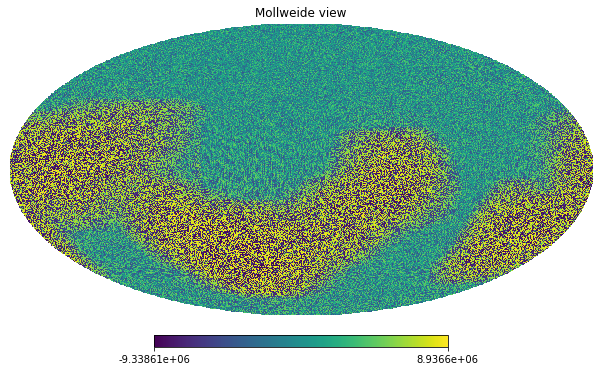

In [60]:
elm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_rinf_tol4/ivfs/sim_0000_elm.fits')
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_rinf_tol4/ivfs/sim_0000_blm.fits')
plt.plot(hp.alm2cl(elm), label='ClEE')
plt.plot(hp.alm2cl(blm), label='ClBB')

plt.title('OBD test', fontsize=16)
plt.xlabel('Multipole', fontsize=16)
plt.ylabel('$C_L L^4$', fontsize=16)

plt.yscale('log')
plt.ylim(1e-2,1e7)
plt.xlim(0,300)
plt.show()
emap = hp.alm2map(elm, nside=2048)
bmap = hp.alm2map(blm, nside=2048)
hp.mollview(bmap, norm='hist')

Text(-1.3413895611048, 0.5185471423507488, 'r10 redi imdi solver')

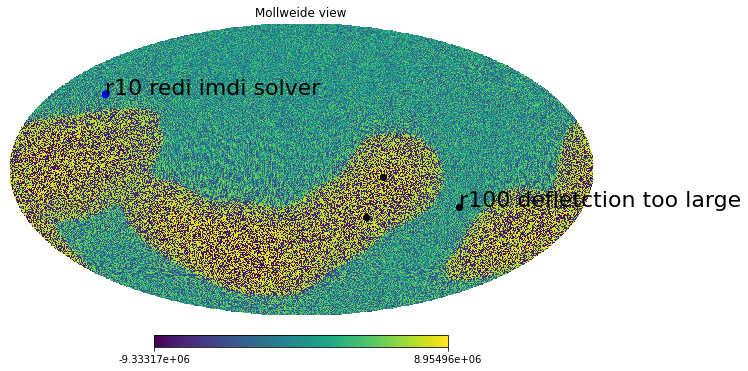

In [79]:
hp.mollview(bmap, norm='hist')
hp.visufunc.projscatter(theta=1.6296791075465420, phi=5.3988851528357928, lonlat=False, color='black')
hp.visufunc.projscatter(theta=1.9861162068333398, phi=5.5411476673863715, lonlat=False, color='black')
hp.visufunc.projscatter(theta=1.8924901406264949, phi=4.5318296886833762, lonlat=False, color='black')
hp.visufunc.projtext(theta=1.8924901406264949, phi=4.5318296886833762, lonlat=False, s='r100 defletction too large', fontsize=22)

In [44]:
mask_ = hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_rhits_positive_nonan.fits')


In [77]:
qu = sims.get_sim_pmap(0)

In [87]:
nqu = sims.get_noise_sim_pmap(0)

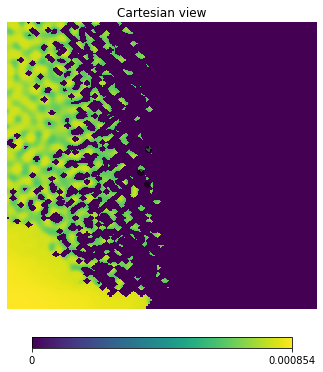

In [95]:
backg = mask_
# hp.cartview(backg, lonra=[60,64], latra=[-3, 0])
hp.cartview(backg, norm='hist', lonra=[55,69], latra=[-8, 5])
# hp.cartview(backg, norm='hist', lonra=[45,79], latra=[-18, 15])
# hp.cartview(backg, lonra=[35,40], latra=[-16, -13])
hp.visufunc.projscatter(theta=90.719730095593093/180*np.pi, phi=62.622222222222220/180*np.pi, lonlat=False, color='black', alpha=0.5)
hp.visufunc.projscatter(theta=92.339122810668314/180*np.pi, phi=62.666666666666671/180*np.pi, lonlat=False, color='black', alpha=0.5)
hp.visufunc.projscatter(theta=91.754342108004565/180*np.pi, phi=62.977777777777781/180*np.pi, lonlat=False, color='black', alpha=0.5)

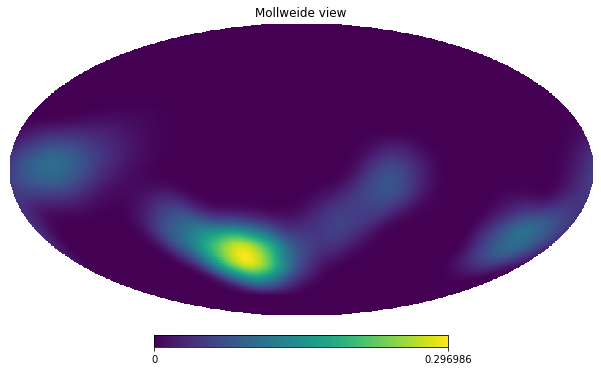

In [4]:
msk = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/fmask.fits.gz')
from lerepi.config.config_helper import data_functions as df
noisemodel_rhits_map = df.get_nlev_mask(np.inf, hp.read_map('/global/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08d/masks/08d_rhits_positive_nonan.fits'))
noisemodel_rhits_map[noisemodel_rhits_map == np.inf] = 0
hp.mollview(noisemodel_rhits_map)

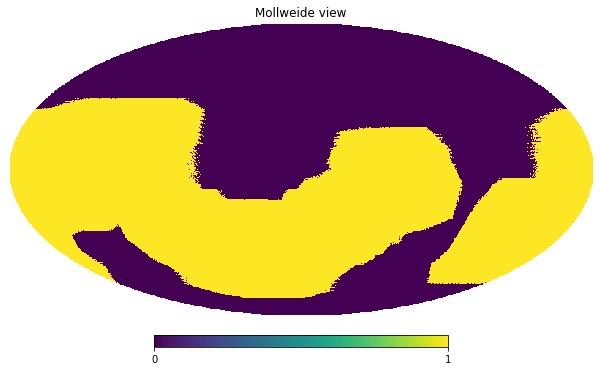

In [85]:
hits_ratio = np.inf
pix = np.where(df.get_nlev_mask(hits_ratio, noisemodel_rhits_map))[0]
pixwhere = np.where(df.get_nlev_mask(hits_ratio, noisemodel_rhits_map),1,0)
hp.mollview(pixwhere)

In [86]:
# hits_ratio = 2
pix = np.where(df.get_nlev_mask(hits_ratio, noisemodel_rhits_map))[0]
tht, phi = hp.pix2ang(2048, pix, nest=False)
thtminmax = np.max(tht), np.min(tht)
zbounds = np.cos(thtminmax)
print(zbounds)

[-0.95002357  0.59863281]


In [87]:
zbounds = df.get_zbounds(noisemodel_rhits_map, hits_ratio)
print(zbounds)
zbounds_len = df.extend_zbounds(zbounds)

(-0.9500235716501871, 0.5986328125)


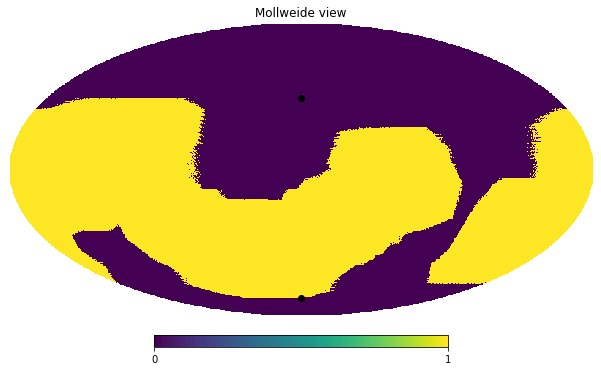

In [92]:
hp.mollview(pixwhere)
hp.projscatter(theta=np.arccos(zbounds[0]), phi=0, lonlat=False, color='black')
hp.projscatter(theta=np.arccos(zbounds[1]), phi=0, lonlat=False, color='black')

# Check r5

In [124]:
zbounds = df.get_zbounds(noisemodel_rhits_map, 5)
zbounds_len = df.extend_zbounds(zbounds)
print(zbounds, zbounds_len)
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/sim_0000_blm.fits')
bmap = hp.alm2map(blm, nside=2048)

(-0.9040126005808512, 0.24414062499999997) [-0.9378321461477812, 0.3277299921484907]


In [127]:
print(np.arccos(zbounds_len))

[2.78712717 1.23689646]


In [ ]:
-0.9040126005808512, 0.24414062499999997) [-0.9378321461477812, 0.3277299921484907]

In [1]:
pixwhere = np.where(df.get_nlev_mask(5, noisemodel_rhits_map),1,0)
hp.mollview(pixwhere)
# hp.mollview(bmap, norm='hist', title='r5 redi imdi solver fails')
thetas0 = [np.arccos(zbounds[0]) for n in np.arange(-25,25,50/20)]
thetas1 = [np.arccos(zbounds[1]) for n in np.arange(-25,25,50/20)]
phis =[n for n in np.arange(-3,3,(6/20))]
for theta0, theta1, phi in zip(thetas0, thetas1, phis):
    hp.projscatter(theta0, phi, lonlat=False, color='grey')
    hp.projscatter(theta1, phi, lonlat=False, color='grey')
    
thetas0 = [np.arccos(zbounds_len[0]) for n in np.arange(-25,25,50/20)]
thetas1 = [np.arccos(zbounds_len[1]) for n in np.arange(-25,25,50/20)]
phis =[n for n in np.arange(-3,3,(6/20))]
for theta0, theta1, phi in zip(thetas0, thetas1, phis):
    hp.projscatter(theta0, phi, lonlat=False, color='black')
    hp.projscatter(theta1, phi, lonlat=False, color='black')
    
hp.graticule()

hp.visufunc.projscatter(theta=134.57828270306976, phi=39.119999999999997, lonlat=True, color='blue')
hp.visufunc.projscatter(theta=134.57828270306976, phi=39.119999999999997, lonlat=True, color='blue')
hp.visufunc.projscatter(theta=134.57828270306976, phi=39.119999999999997, lonlat=True, color='blue')
hp.visufunc.projscatter(theta=134.57828270306976, phi=39.119999999999997, lonlat=True, color='blue')

NameError: name 'np' is not defined

# Delensing efficiency

In [50]:
from plancklens.sims import planck2018_sims
from plancklens import utils
idx = 0
beam = 2.3
m0 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/fmask.fits.gz')
transf_elm_loc = hp.gauss_beam(beam/180 / 60 * np.pi, lmax=4000)
blm_L_buff = hp.almxfl(utils.alm_copy(planck2018_sims.cmb_unl_ffp10.get_sim_plm(idx), lmax=4000), transf_elm_loc)
bmap_L_buff = hp.alm2map(blm_L_buff, 2048)*m0
blm_L_buff_scaled = hp.map2alm(bmap_L_buff, lmax=4000)
# bcl_L_nm = self.lib_nm[nlev].map2cl(bmap_L_buff)
# self.lib_nm.update({nlev: ps.map2cl_binned(nlev_mask, self.bmd_model.clc_templ[:self.bmd_model.lmax_lib], self.bmd_model.edges, self.bmd_model.lmax_lib)})

(0.0, 2000.0)

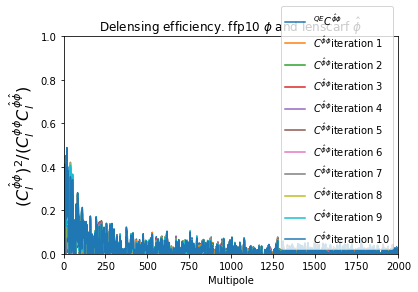

In [51]:
ls = np.arange(2,2500)
for idx, pout in enumerate(plms):
    if idx == 0:
        label = r'$^{QE}C^{\hat{\phi}\phi}$'
    else:
        label = r'$C^{\hat{\phi}\phi}$'+ 'iteration {}'.format(range(12)[idx])
    plt.plot(ls, (hp.alm2cl(pout, blm_L_buff_scaled)[ls]/np.sqrt(hp.alm2cl(blm_L_buff_scaled)[ls] * hp.alm2cl((pout))[ls])), label=label)

    plt.title(r'Delensing efficiency. ffp10 $\phi$ and lenscarf $\hat{\phi}$')
plt.xlabel('Multipole')
plt.ylabel(r'$(C_l^{\hat{\phi}\phi})^2/(C_l^{\phi\phi}C_l^{\hat{\phi}\hat{\phi}})$', fontsize=16)
plt.legend()

plt.ylim((0.0,1))
plt.xlim((0,2000))

In [45]:
blm_L_buff_scaled.shape
# pout.shape

(8394753,)

# Mask

In [2]:
import healpy as hp
m0 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r5/ivfs/fmask.fits.gz')
m1 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r10/ivfs/fmask.fits.gz')
m2 = hp.read_map('/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF100_r100/ivfs/fmask.fits.gz')

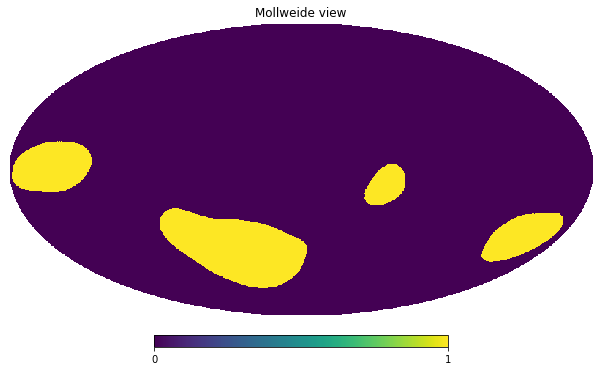

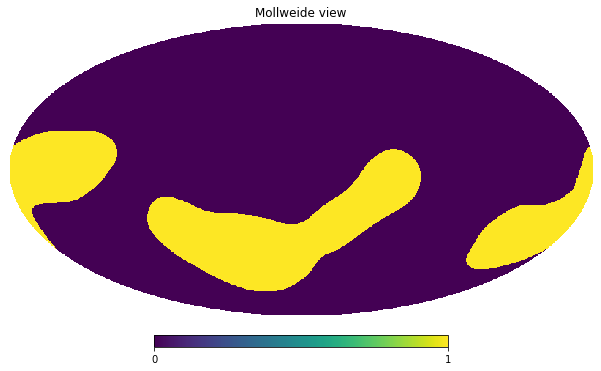

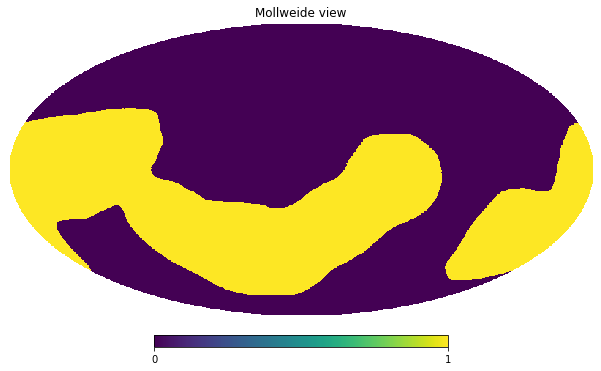

In [3]:
hp.mollview(m0)
hp.mollview(m1)
hp.mollview(m2)

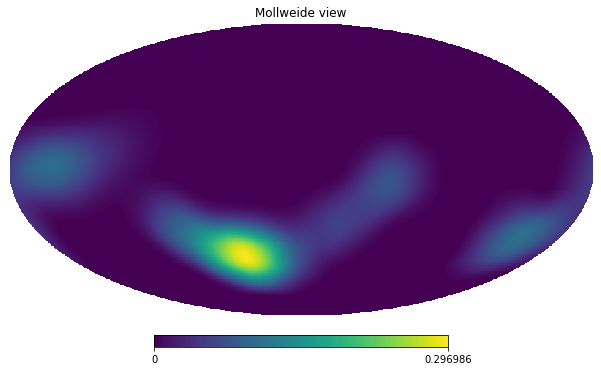

In [63]:
mask = hp.read_map('/global/homes/s/sebibel/git/lerepi/lerepi/data/dc08/masks/mask_r100.fits')
hp.mollview(mask)